In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from util import target_encoding

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import os
print(os.listdir("../data"))

['periods_test.csv', 'periods_train.csv', 'sample_submission.csv', 'test.csv', 'test_active.csv', 'test_jpg', 'train.csv', 'train_active.csv', 'train_jpg']


In [3]:
train_dat = pd.read_csv("../data/train.csv",parse_dates=["activation_date"])
test_dat = pd.read_csv("../data/test.csv",parse_dates=["activation_date"])
print('train data shape: ', train_dat.shape)
print('test data shape: ', test_dat.shape)

train data shape:  (1503424, 18)
test data shape:  (508438, 17)


In [4]:
data = pd.concat([train_dat, test_dat], axis = 0)
data.shape

(2011862, 18)

In [5]:
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm

In [6]:
data.head()

,activation_date,category_name,city,deal_probability,description,image,image_top_1,item_id,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,user_id,user_type
0,2017-03-28,Товары для детей и игрушки,Екатеринбург,0.12789,"Кокон для сна малыша,пользовались меньше месяц...",d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00000,b912c3c6a6ad,2,Постельные принадлежности,NaN,NaN,Личные вещи,400.00000,Свердловская область,Кокоби(кокон для сна),e00f8ff2eaf9,Private
1,2017-03-26,Мебель и интерьер,Самара,0.00000,"Стойка для одежды, под вешалки. С бутика.",79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00000,2dac0150717d,19,Другое,NaN,NaN,Для дома и дачи,3000.00000,Самарская область,Стойка для Одежды,39aeb48f0017,Private
2,2017-03-20,Аудио и видео,Ростов-на-Дону,0.43177,"В хорошем состоянии, домашний кинотеатр с blu ...",b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00000,ba83aefab5dc,9,"Видео, DVD и Blu-ray плееры",NaN,NaN,Бытовая электроника,4000.00000,Ростовская область,Philips bluray,91e2f88dd6e3,Private
3,2017-03-25,Товары для детей и игрушки,Набережные Челны,0.80323,Продам кресло от0-25кг,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.00000,02996f1dd2ea,286,Автомобильные кресла,NaN,NaN,Личные вещи,2200.00000,Татарстан,Автокресло,bf5cccea572d,Company
4,2017-03-16,Автомобили,Волгоград,0.20797,Все вопросы по телефону.,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.00000,7c90be56d2ab,3,С пробегом,ВАЗ (LADA),2110,Транспорт,40000.00000,Волгоградская область,"ВАЗ 2110, 2003",ef50846afc0b,Private


In [7]:
def feature_engineering(dat):
    dat['day_of_month'] = dat.activation_date.dt.day
    dat['day_of_week'] = dat.activation_date.dt.weekday
    
    dat['title'] = dat['title'].fillna(" ")
    dat['title_len'] = dat['title'].apply(lambda x : len(x.split()))

    dat['description'] = dat['description'].fillna(" ")
    dat['description_len'] = dat['description'].apply(lambda x : len(x.split()))
    
#     pr_train['total_period'] = pr_train['date_to'] - pr_train['date_from']

    daymap = {0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}
    dat['day_of_week_en'] = dat['day_of_week'].apply(lambda x : daymap[x])
    
    dat['deal_class'] = dat['deal_probability'].apply(lambda x: ">=0.5" if x >=0.5 else "<0.5")

    interval = (-0.99, .10, .20, .30, .40, .50, .60, .70, .80, .90, 1.1)
    cats = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9','0.9-1.0']
    dat["deal_class_2"] = pd.cut(dat.deal_probability, interval, labels=cats)
    
    return dat

train_dat = feature_engineering(train_dat)
train_dat.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,image,image_top_1,deal_probability,day_of_month,day_of_week,title_len,description_len,day_of_week_en,deal_class,deal_class_2
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00000,0.12789,28,1,3,7,Mon,<0.5,0.1-0.2
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00000,0.00000,26,6,3,7,Sat,<0.5,0-0.1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00000,0.43177,20,0,2,17,Sun,<0.5,0.4-0.5
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.00000,0.80323,25,5,1,3,Fri,>=0.5,0.8-0.9
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.00000,0.20797,16,3,3,4,Wed,<0.5,0.2-0.3


In [8]:
data = feature_engineering(data)
data.head()

,activation_date,category_name,city,deal_probability,description,image,image_top_1,item_id,item_seq_number,param_1,...,title,user_id,user_type,day_of_month,day_of_week,title_len,description_len,day_of_week_en,deal_class,deal_class_2
0,2017-03-28,Товары для детей и игрушки,Екатеринбург,0.12789,"Кокон для сна малыша,пользовались меньше месяц...",d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00000,b912c3c6a6ad,2,Постельные принадлежности,...,Кокоби(кокон для сна),e00f8ff2eaf9,Private,28,1,3,7,Mon,<0.5,0.1-0.2
1,2017-03-26,Мебель и интерьер,Самара,0.00000,"Стойка для одежды, под вешалки. С бутика.",79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00000,2dac0150717d,19,Другое,...,Стойка для Одежды,39aeb48f0017,Private,26,6,3,7,Sat,<0.5,0-0.1
2,2017-03-20,Аудио и видео,Ростов-на-Дону,0.43177,"В хорошем состоянии, домашний кинотеатр с blu ...",b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00000,ba83aefab5dc,9,"Видео, DVD и Blu-ray плееры",...,Philips bluray,91e2f88dd6e3,Private,20,0,2,17,Sun,<0.5,0.4-0.5
3,2017-03-25,Товары для детей и игрушки,Набережные Челны,0.80323,Продам кресло от0-25кг,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.00000,02996f1dd2ea,286,Автомобильные кресла,...,Автокресло,bf5cccea572d,Company,25,5,1,3,Fri,>=0.5,0.8-0.9
4,2017-03-16,Автомобили,Волгоград,0.20797,Все вопросы по телефону.,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.00000,7c90be56d2ab,3,С пробегом,...,"ВАЗ 2110, 2003",ef50846afc0b,Private,16,3,3,4,Wed,<0.5,0.2-0.3


In [9]:
agg_cols = ['region', 'city', 'parent_category_name', 'category_name',
            'image_top_1', 'user_type','item_seq_number','day_of_month','day_of_week'];
for c in tqdm(agg_cols):
    gp = train_dat.groupby(c)['deal_probability']
    mean = gp.mean()
    std  = gp.std()
    data[c + '_deal_probability_avg'] = data[c].map(mean)
    data[c + '_deal_probability_std'] = data[c].map(std)

for c in tqdm(agg_cols):
    gp = train_dat.groupby(c)['price']
    mean = gp.mean()
    std  = gp.std()
    data[c + '_price_avg'] = data[c].map(mean)
    data[c + '_price_std'] = data[c].map(std)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.56it/s]


In [23]:
cate_cols = ['city',  'category_name', 'user_type','parent_category_name','region']
for c in cate_cols:
    data[c] = LabelEncoder().fit_transform(data[c].values)

cate_cols = ['city',  'category_name', 'user_type','parent_category_name','region']
for c in cate_cols:
    trn_tf, val_tf = target_encoding.target_encode(trn_series=train_dat[c], 
                                   tst_series=test_dat[c], 
                                   target=train_dat.deal_probability, 
                                   min_samples_leaf=100, 
                                   smoothing=20,
                                   noise_level=0.01)
    data[c+'_tgt_encoding'] = trn_tf.append(val_tf, ignore_index=True)

In [24]:
data.head()

,activation_date,category_name,city,deal_probability,description,image,image_top_1,item_id,item_seq_number,param_1,...,item_seq_number_price_std,day_of_month_price_avg,day_of_month_price_std,day_of_week_price_avg,day_of_week_price_std,city_tgt_encoding,category_name_tgt_encoding,user_type_tgt_encoding,parent_category_name_tgt_encoding,region_tgt_encoding
0,2017-03-28,42,462,0.12789,"Кокон для сна малыша,пользовались меньше месяц...",d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00000,b912c3c6a6ad,2,Постельные принадлежности,...,345853039.99501,287737.29210,2458544.30545,297584.41172,3171434.60549,0.12349,0.19942,0.15084,0.07711,0.12090
1,2017-03-26,22,1314,0.00000,"Стойка для одежды, под вешалки. С бутика.",79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00000,2dac0150717d,19,Другое,...,1733707.48974,134221.06291,1800657.58246,139524.73120,2311828.02334,0.13967,0.18986,0.15024,0.18130,0.13560
2,2017-03-20,2,1290,0.43177,"В хорошем состоянии, домашний кинотеатр с blu ...",b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00000,ba83aefab5dc,9,"Видео, DVD и Blu-ray плееры",...,12482332.31402,292207.07159,4585388.64645,308329.93690,5412326.17131,0.12591,0.16947,0.14797,0.17311,0.13582
3,2017-03-25,42,950,0.80323,Продам кресло от0-25кг,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.00000,02996f1dd2ea,286,Автомобильные кресла,...,1189166.67959,195362.57067,3648377.31452,193209.39989,4716040.01646,0.13214,0.19939,0.12494,0.07468,0.13995
4,2017-03-16,0,318,0.20797,Все вопросы по телефону.,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.00000,7c90be56d2ab,3,С пробегом,...,2367744.26044,293572.15698,7000434.36175,299911.62518,5637077.39044,0.13655,0.27383,0.14587,0.26391,0.14537


In [25]:
new_data = data.drop(['user_id','description','image',#'parent_category_name','region',
                      'item_id','param_1','param_2','param_3','title','deal_class','deal_class_2','day_of_week_en'], axis=1)

In [26]:
import gc
gc.collect()

548

In [27]:
from sklearn.model_selection import train_test_split
X = new_data.loc[new_data.activation_date<=pd.to_datetime('2017-04-07')]
X_te = new_data.loc[new_data.activation_date>=pd.to_datetime('2017-04-08')]

y = X['deal_probability']
X = X.drop(['deal_probability','activation_date'],axis=1)
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=2018)
X_te = X_te.drop(['deal_probability','activation_date'],axis=1)

print(X_tr.shape, X_va.shape, X_te.shape)

gc.collect()

(1202739, 53) (300685, 53) (508438, 53)


0

In [28]:
# Create the LightGBM data containers
tr_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cate_cols)
va_data = lgb.Dataset(X_va, label=y_va, categorical_feature=cate_cols, reference=tr_data)
gc.collect()

0

In [29]:
# Train the model
parameters = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 50
}


model = lgb.train(parameters,
                  tr_data,
                  valid_sets=va_data,
                  num_boost_round=2000,
                  early_stopping_rounds=120,
                  verbose_eval=50)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 120 rounds.
[50]	valid_0's rmse: 0.230107
[100]	valid_0's rmse: 0.228148
[150]	valid_0's rmse: 0.227463
[200]	valid_0's rmse: 0.227057
[250]	valid_0's rmse: 0.226805
[300]	valid_0's rmse: 0.226635
[350]	valid_0's rmse: 0.226528
[400]	valid_0's rmse: 0.226409
[450]	valid_0's rmse: 0.226328
[500]	valid_0's rmse: 0.226266
[550]	valid_0's rmse: 0.226207
[600]	valid_0's rmse: 0.226152
[650]	valid_0's rmse: 0.226097
[700]	valid_0's rmse: 0.226054
[750]	valid_0's rmse: 0.22601
[800]	valid_0's rmse: 0.225985
[850]	valid_0's rmse: 0.225953
[900]	valid_0's rmse: 0.225935
[950]	valid_0's rmse: 0.225905
[1000]	valid_0's rmse: 0.225888
[1050]	valid_0's rmse: 0.225878
[1100]	valid_0's rmse: 0.225868
[1150]	valid_0's rmse: 0.225861
[1200]	valid_0's rmse: 0.225836
[1250]	valid_0's rmse: 0.225821
[1300]	valid_0's rmse: 0.225799
[1350]	valid_0's rmse: 0.225798
[1400]	valid_0's rmse: 0.225787
[1450]	valid_0's rmse: 0.225766
[1500]	valid_0's rmse: 0.22575

In [31]:
# 0.225676 / 0.225669
y_pred = model.predict(X_te)
sub = pd.read_csv('../data/sample_submission.csv')
sub['deal_probability'] = y_pred
sub['deal_probability'].clip(0.0, 1.0, inplace=True)
sub.to_csv('../submissions/lgb_with_mean_encode.csv', index=False)
sub.head()

,item_id,deal_probability
0,6544e41a8817,0.03043
1,65b9484d670f,0.16219
2,8bab230b2ecd,0.15015
3,8e348601fefc,0.17741
4,8bd2fe400b89,0.30581


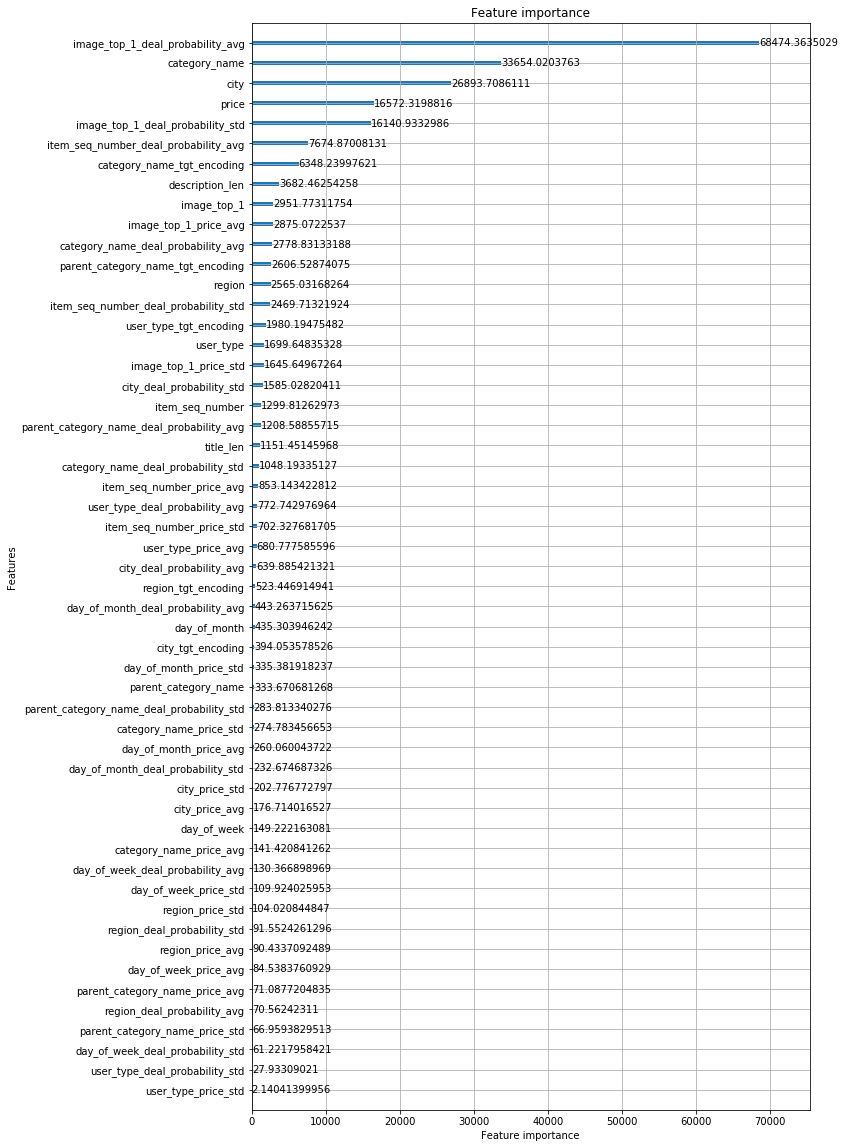

In [33]:
lgb.plot_importance(model, importance_type='gain', figsize=(10,20))

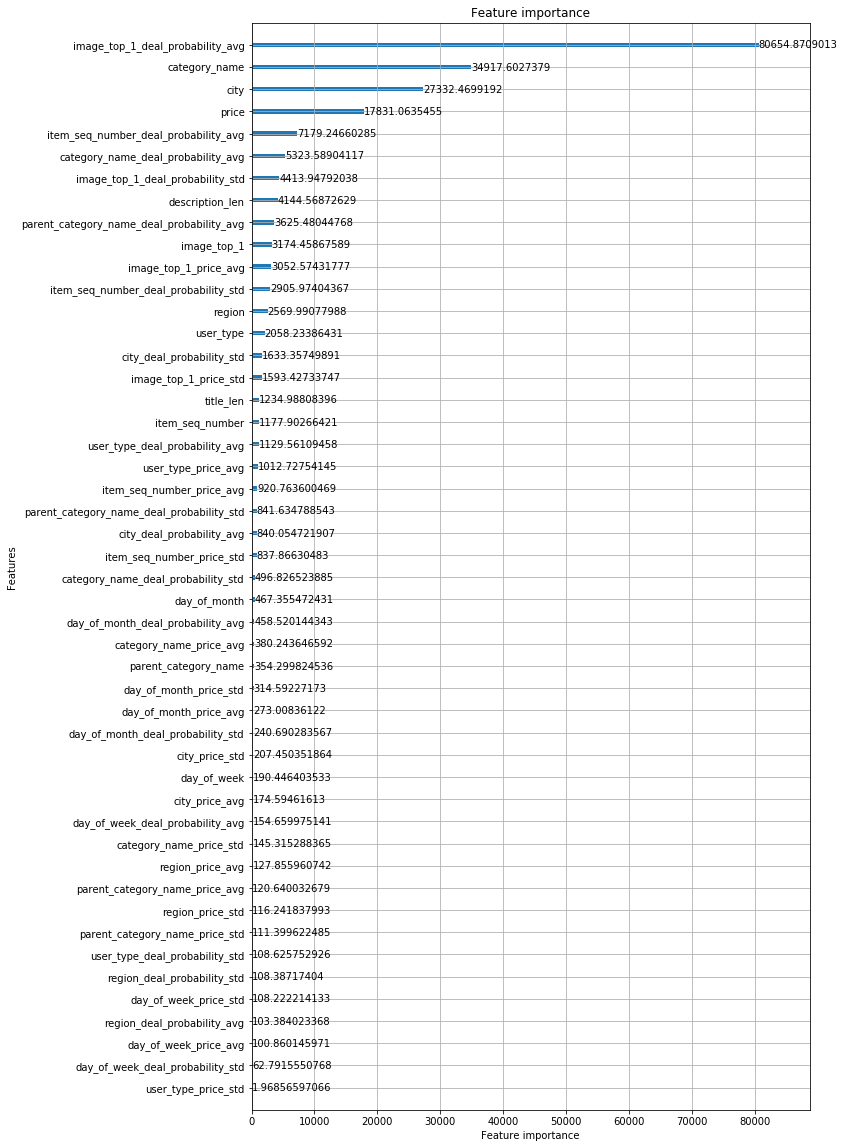

In [17]:
lgb.plot_importance(model, importance_type='gain', figsize=(10,20))